In [1]:
import tqdm
import scipy.stats
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
from functools import partial
from scipy.special import softmax, logsumexp

In [2]:
class DeterministicUsageGenerator:

    def __init__(self, scale=1, n_uses=5, dt=1/12, seed=None):
        self.dt = dt
        self.seed = seed
        self.n = int(round(24 / self.dt))
        self.x = np.linspace(0, 24 - self.dt, self.n)

        np.random.seed(self.seed)

        # get distribution parameters
        self.p = 0
        self.mu = []
        self.sig = []
        for _ in range(n_uses):
            self.mu.append((20 if np.random.rand() > 0.5 else 8) + np.random.randn())
            self.sig.append(0.25 + np.random.gamma(1, 0.25))

            # add event
            self.p += scale * scipy.stats.norm(self.mu[-1], self.sig[-1]).pdf(self.x)

        # add deterministic events (p=0,1)
        self.p += 0.1 * np.random.rand(self.n) * self.dt
        self.p = np.clip(self.p, 0, 1).round()
        if np.all(self.p == 0):
            self.p[np.random.randint(len(self.p))] = 1

    def sample(self, n_samples=1):
        return np.ones((n_samples, self.n)) == self.p[None]

In [3]:
class DeterministicOptimizer:

    def __init__(self, pw, r_cool=0.02, r_heat=10.0, r_loss=20.0, x_max=60, x_min=40, x_amb=24,
                 dx=1/5, dt=1/12, alpha=1, price=None):
        """Simple optimizer for binary demand.

        Parameters
        ----------
        pw : np.array
            Density for hot water demand. The length should be equal to 24//dt.
        r_cool : float
            Rate at which heat is lost to the environment. Default is 0.02.
        r_heat : float
            Heating rate. Default is 10.0.
        r_loss : float
            Multiplier for w. Default is 20.0.
        x_max : float
            Maximum temperature of the water heater (Celsius). Default is 60.
        x_min : float
            Minimum desired temperature (Celsius). Default is 40.
        x_amb : float
            Ambient temperature of the environment (Celsius). Default is 24.
        dx : float
            Temperature step. Default is 1/5.
        dt : float
            Time step (hours). Default is 1/12 (5 minutes).
        alpha : float
            Trade off parameter that converts units of discomfort cost to units of power cost.
        price : np.array
            Array containing the price for power.
        """

        self.pw = np.vstack([1-pw, pw]).T
        self.r_cool = r_cool
        self.r_heat = r_heat
        self.r_loss = r_loss
        self.x_max = x_max
        self.x_min = x_min
        self.x_amb = x_amb
        self.dx = dx
        self.dt = dt
        self.alpha = alpha

        self.Nt = int(round(24 / self.dt))
        assert len(self.pw) == self.Nt, f"Length of pw ({len(self.pw)}) must be equal to 24/dt ({self.Nt})."

        self.x_grid = np.arange(self.x_amb, self.x_max + self.dx, self.dx)
        self.t_grid = np.arange(0, 24, self.dt)
        self.w_grid = np.arange(2)
        self.u_grid = np.arange(2)
        self.price = np.ones(self.Nt) if price is None else price
        self.Nx = len(self.x_grid)
        self.Nw = 2
        self.Nu = 2

        # calculate transition probabilities
        self.P = np.zeros((self.Nx, self.Nx, self.Nt, self.Nu))
        i = self.round_state_to_index(self.x_grid)

        for u in self.u_grid:
            for w in self.w_grid:

                x_next = self.f(self.x_grid, u, w)
                j = self.round_state_to_index(x_next)

                x_round = self.round_to_nearest_state(x_next)
                shift = np.sign(x_next - x_round).astype(np.int64)
                p = 1 - np.abs(x_next - x_round) / self.dx

                for k in range(self.Nt):
                    self.P[i, j, k, u] += self.pw[k, w]

        # optimize policy
        self.optimize()

    def update_price(self, price):
        self.price = price
        self.optimize()

    def optimize(self):

        # calculate q-values
        self.Q = np.zeros((self.Nt, self.Nx, 2))
        for k in range(self.Nt + 1)[::-1]:

            for u in [0, 1]:
                stage_cost = np.dot(self.pw[k % self.Nt], self.g(k, self.x_grid, u, self.w_grid[:, None]))
                cost_to_go = np.sum(self.P[:, :, k % self.Nt, u] * self.Q[(k + 1) % self.Nt].min(-1), 1)
                self.Q[k % self.Nt, :, u] = stage_cost + cost_to_go

        # calculate policy
        self.policy = np.argmin(self.Q, -1)

    def calculate_expected_usage(self):

        # initialize state to be halfway between x_amb and x_max
        x = self.round_to_nearest_state((self.x_max + self.x_amb)/2)

        # calculate trajectories
        action_trajectory = np.zeros(self.Nt)
        state_trajectory = np.zeros(self.Nt)

        for k in range(self.Nt):

            # store current values
            u = self.policy[k % self.Nt, self.round_state_to_index(x)]
            action_trajectory[k] = u
            state_trajectory[k] = x

            # calculate next state
            w = np.where(self.pw[k % self.Nt])[0][0]
            x = self.round_to_nearest_state(self.f(x, u, w))

        # calculate state distribution
        state_distribution = np.zeros((self.Nt, self.Nx))
        for k, i in enumerate(self.round_state_to_index(state_trajectory)):
            state_distribution[k, i] = 1

        return state_distribution, action_trajectory

    def round_to_nearest_state(self, x):
        return np.round(x / self.dx) * self.dx

    def round_state_to_index(self, x):
        return np.round((x - self.x_amb) / self.dx).astype(np.int64)

    def f(self, x, u, w):
        x = x + (-self.r_cool * (x - self.x_amb) + self.r_heat * u - self.r_loss * w) * self.dt
        return np.clip(x, self.x_amb, self.x_max)

    def g_power(self, k, u):
        return self.price[k % self.Nt]*u

    def g_discomfort(self, x, w):
        return np.maximum(self.x_min - x, 0) * (w > 0)

    def g(self, k, x, u, w):
        power_cost = self.g_power(k, u)
        discomfort_cost = self.g_discomfort(x, w)
        return power_cost + self.alpha * discomfort_cost

In [4]:
def calculate_cost(price, group_load, group_discomfort):
    """"""    
    total_load = group_load.sum(0)
    system_cost = logsumexp(total_load)
    monetary_cost = np.dot(total_load, price)
    discomfort_cost = group_discomfort.sum()
    cost = discomfort_cost + system_cost
    return cost, system_cost, monetary_cost, discomfort_cost


def extract_device_info(seed, price, dt=1/4):
    
    # define and optimize user
    usage_generator = DeterministicUsageGenerator(scale=0.25, n_uses=20, dt=dt, seed=seed)
    optimizer = DeterministicOptimizer(usage_generator.p, price=price, dt=dt, alpha=5e-3)
    state_distribution, load = optimizer.calculate_expected_usage()
  
    # calculate discomfort
    discomfort = optimizer.alpha * optimizer.g_discomfort(optimizer.x_grid, 1)
    discomfort = (discomfort * np.tile(optimizer.pw[:,1], 1)[:,None])
    discomfort = np.sum(state_distribution * discomfort, 1)

    return discomfort, load


def get_price(price, group_load, beta, gamma=0.5):
    update = gamma*softmax(group_load.sum(0))
    return (1 - beta)*price + beta*update

In [5]:
# initialize
N_USERS = 10
N_ITER = 5000
INIT_BETA = 0.5

dt = 1/4
Nt = int(24//dt)

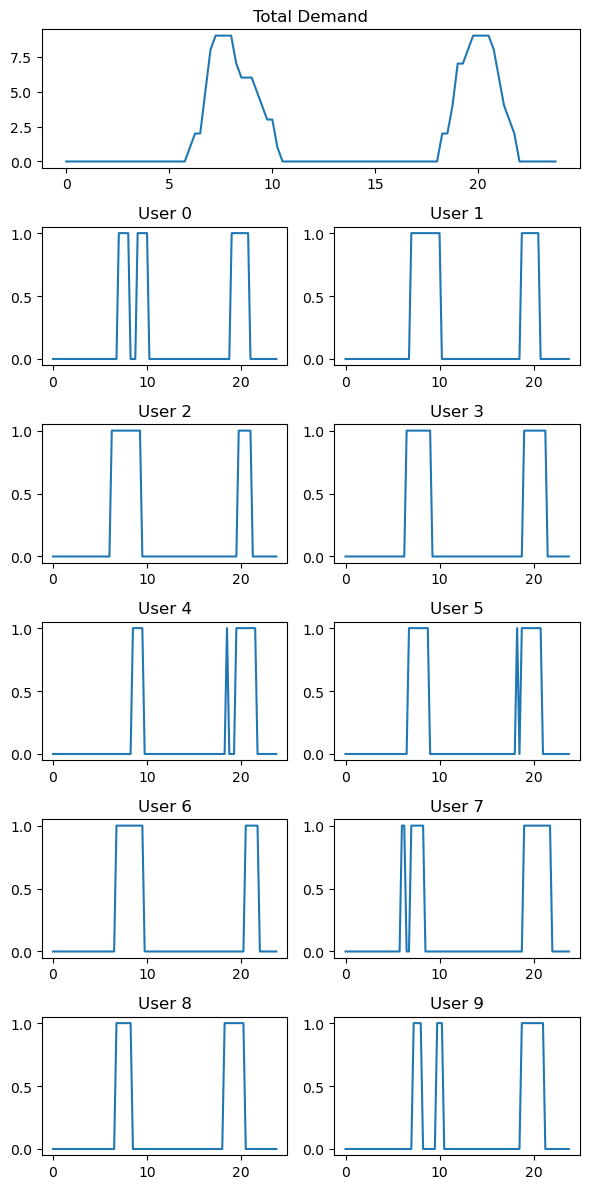

In [6]:
# plot demand
plt.figure(figsize=(6, 12))
total_demand = 0
for seed in range(10):
    usage_generator = DeterministicUsageGenerator(scale=0.25, n_uses=20, dt=dt, seed=seed)
    total_demand += usage_generator.p
        
    plt.subplot(6, 2, seed+3)
    plt.plot(np.arange(96)/4, usage_generator.p)
    plt.title(f"User {seed}")

plt.subplot(6, 2, (1,2))
plt.plot(np.arange(96)/4, total_demand)
plt.title("Total Demand")
plt.tight_layout()    

In [7]:
for _ in tqdm.tqdm(range(1000), desc="Check that x*(p) is decreasing"):
    
    usage_generator = DeterministicUsageGenerator(scale=0.25, n_uses=20, dt=dt, seed=None)

    price1 = np.random.rand(Nt)
    optimizer1 = DeterministicOptimizer(usage_generator.p, price=price1, dt=dt)
    _, load1 = optimizer1.calculate_expected_usage()

    price2 = np.random.rand(Nt)
    optimizer2 = DeterministicOptimizer(usage_generator.p, price=price2, dt=dt)
    _, load2 = optimizer2.calculate_expected_usage()

    assert np.dot(load1 - load2, price1 - price2) < 0

Check that x*(p) is decreasing: 100%|█████████████████████████████████████████████| 1000/1000 [01:01<00:00, 16.16it/s]


In [8]:
%%time

pool = multiprocessing.Pool(10)

# calculate initial values
init_price = 0.01*np.ones(Nt)

device_info = pool.map(partial(extract_device_info, price=init_price, dt=dt), range(N_USERS))
group_discomfort = np.array([x[0] for x in device_info])
group_load = np.array([x[1] for x in device_info])

init_group_load = group_load
init_cost, init_system_cost, init_monetary_cost, init_discomfort_cost = \
    calculate_cost(init_price, group_load, group_discomfort)

# run simulation
price = init_price
beta = INIT_BETA
for it in tqdm.tqdm(range(N_ITER)):
    
    # update price
    price = get_price(price, group_load, beta=beta)

    # optimize users
    device_info = pool.map(partial(extract_device_info, price=price, dt=dt), range(N_USERS))
    group_load = np.array([x[1] for x in device_info])

    # decrease stepsize
    if ((it+1) % 10) == 0:
        beta *= 0.9

pool.close()    

# calculate final values
final_price = price
final_group_load = group_load
group_discomfort = np.array([x[0] for x in device_info])
final_cost, final_system_cost, final_monetary_cost, final_discomfort_cost = \
    calculate_cost(final_price, group_load, group_discomfort)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [05:20<00:00, 15.61it/s]

CPU times: user 12.6 s, sys: 2.28 s, total: 14.9 s
Wall time: 5min 20s


In [9]:
print(
    f"overall cost:     {init_cost:<9.7g}  {final_cost:<9.7g}\n"
    f"system cost:      {init_system_cost:<9.7g}  {final_system_cost:<9.7g}\n"
    f"monetary cost:    {init_monetary_cost:<9.7g}  {final_monetary_cost:<9.7g}\n"
    f"discomfort cost:  {init_discomfort_cost:<9.7g}  {final_discomfort_cost:<9.7g}\n"
)

overall cost:     13.41153   11.02413 
system cost:      12.78153   10.39713 
monetary cost:    3.47       2.344785 
discomfort cost:  0.63       0.627    



In [20]:
100*(13.41153 - 11.02413) / 13.41153

17.801100992951596

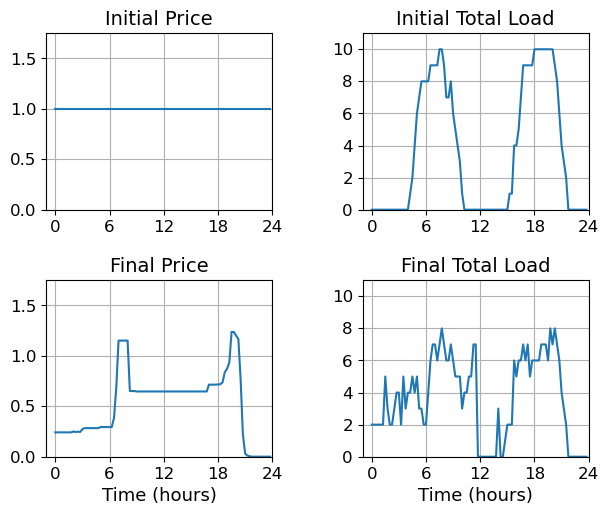

In [21]:
t_grid = np.arange(0, 24, dt)

# plot results
plt.figure(figsize=(7, 5.5))
plt.rcParams.update({"font.size": 13})
plt.rcParams.update({"axes.titlesize": 14})


plt.subplot(2, 2, 1)
plt.plot(t_grid, 100*init_price)
plt.title("Initial Price")
# plt.xlabel("Time (hours)")
plt.gca().tick_params(axis="both", which="major", labelsize=12)
plt.yticks(np.arange(0, 2.0, 0.5))
plt.xticks([0, 6, 12, 18, 24])
plt.ylim(0.0, 1.75)
plt.xlim(-1, 24)
plt.grid()    

plt.subplot(2, 2, 2)
plt.plot(t_grid, init_group_load.sum(0))
plt.title("Initial Total Load")    
# plt.xlabel("Time (hours)")
plt.gca().tick_params(axis="both", which="major", labelsize=12)
plt.yticks(np.arange(0, 12, 2))
plt.xticks([0, 6, 12, 18, 24])
plt.ylim(0, N_USERS+1)
plt.xlim(-1, 24)
plt.grid()


plt.subplot(2, 2, 3)
plt.plot(t_grid, 100*final_price)
plt.title("Final Price")
plt.xlabel("Time (hours)")
plt.gca().tick_params(axis="both", which="major", labelsize=12)
plt.yticks(np.arange(0, 2.0, 0.5))
plt.xticks([0, 6, 12, 18, 24])
plt.ylim(0.0, 1.75)
plt.xlim(-1, 24)
plt.grid()    


plt.subplot(2, 2, 4)
plt.plot(t_grid, final_group_load.sum(0))
plt.title("Final Total Load")
plt.xlabel("Time (hours)")
plt.gca().tick_params(axis="both", which="major", labelsize=12)
plt.yticks(np.arange(0, 12, 2))
plt.xticks([0, 6, 12, 18, 24])
plt.ylim(0, N_USERS+1)
plt.xlim(-1, 24)
plt.grid()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
# plt.tight_layout()